# Classification

#### Dans ce notebook, nous allons mettre en oeuvre et comparer différentes approches de classification pour les séries:
- différents modèle vectoriels: nombre d'occurence des termes, tf-idf, pour des mots/n-grames...
- différents algorithmes de classification: Bayesien Naïf, boosting, SVM, éventuellement NN...
- différents buts: classification par série ou par série-saison
- différentes méthodes de pré-traitement des données: en particulier, différentes "finesses" de tokenization

In [1]:
from utils.load_data import load_data
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from classifiers.naiveBayes import NaiveBayes

Pour tester nos différents modèles, nous allons travailler sur différentes parties de la base de données. Deux versions seront testées à chaque étape: un fragment de la base de données tiré uniformément, et un fragment de la base de données correspondant à des séries célèbres, comportant beaucoup de saisons/épisodes. Nous considérerons qu'un modèle doit à minima donner de bons résultats sur les séries les plus regardées.

In [29]:
path = "dataset"


#liste de séries prédéfinie. Dans notre cas, nous utiliserons également une liste choisie aléatoirement
#selon un tirage uniforme sur le dataset
listeseries = ["2567_House", "2956_Criminal_Minds", "1262_Lost", "175_The_Walking_Dead", "76_Breaking_Bad", "196_Smallville",
"217_Game_of_Thrones", "1906_The_Vampire_Diaries", "3280_Peaky_Blinders", "1704_Rick_and_Morty", "1039_Narcos",
              "1845_Sherlock_(2010)", "1701_Outlander", "3314_Shameless", "818_Gomorra_(2014)", "413_Dexter",
              "2123_Sense8", "121_Suits", "2469_The_Simpsons", "1718_South_Park", "3259_Stargate_SG-1"]

chargement des données des séries prédéfinies:

In [3]:
X_train, X_test, y_train, y_test = load_data(path, series=listeseries, split=True, ratio=0.8)

### Entrainement d'un classifieur Bayesien naïf

- nous commençons par tester la méthode vectorielle du nombre d'occurences

In [4]:
#conversion des données sous forme vectorielle - nombre d'occurence
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=stopwords.words('english'), strip_accents='ascii')
count_vect.fit(X_train + X_test)

xtrain_count = count_vect.transform(X_train)
xtest_count = count_vect.transform(X_test)

print("countVector model:")

NB = NaiveBayes()
accuracy, predictions = NB.fit(xtrain_count, y_train, xtest_count, y_test)

countVector model:
trained on 1869 samples, validated on 468.
accuracy:  0.45085470085470086


#### regardons les séries mal classées:

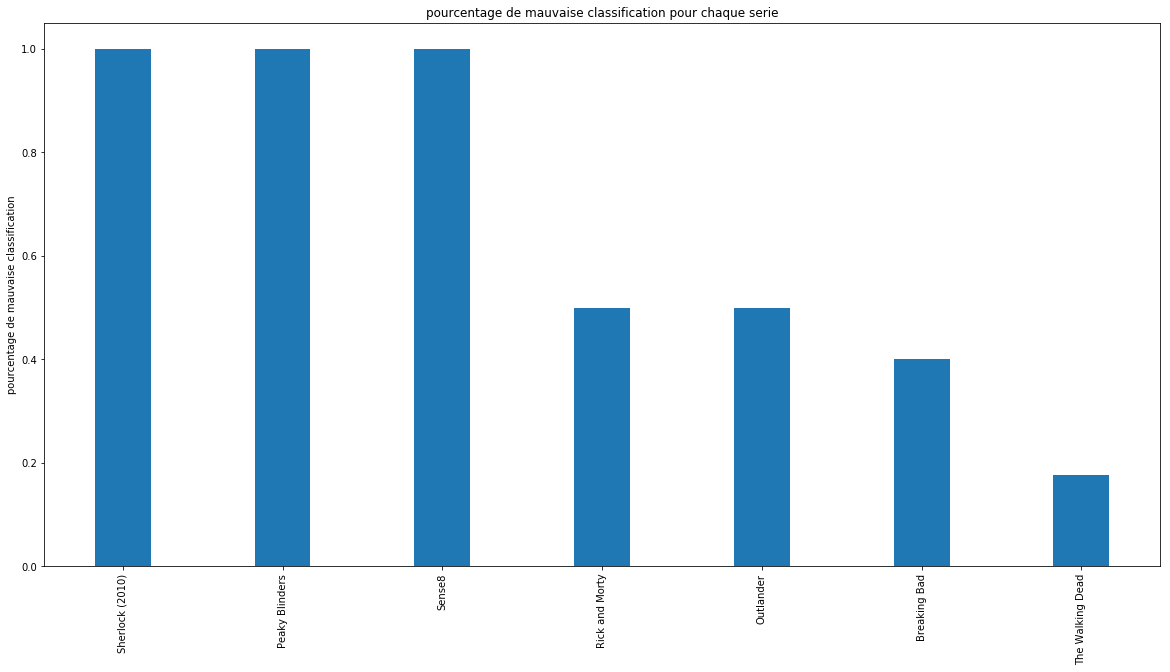

In [5]:
errors = NB.getErrors(y_test, listeseries)

On voit que pour 20 séries, le classifieur s'est trompé sur la moitié d'entre elle. Sachant qu'il y a 20 séries, on peut penser que le classifieur est beaucoup plus performant que l'aléatoire (5% accuracy). En revanche, pour 4 séries, 100% de leurs épisodes ont mal été classifiés. Notre classifieur est incapable de reconnaitre Peaky Blinders, ou Sense8. Ce sont toutes des séries avec très peu d'épisodes (une seule saison/une dizaine d'épisodes par saison). Cette méthode semble donc nécessiter de grandes quantités de données pour fonctionner à peu près correctement.

Testons maintenant des séries aléatoires:

In [6]:
listeSeries, (X_train, X_test, y_train, y_test) = load_data(path, series=[], nbclass=20, random=True, split=True, ratio=0.8)

In [7]:
#conversion des données sous forme vectorielle - nombre d'occurence
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=stopwords.words('english'), strip_accents='ascii')
count_vect.fit(X_train + X_test)

xtrain_count = count_vect.transform(X_train)
xtest_count = count_vect.transform(X_test)

print("countVector model:")

NB = NaiveBayes()
accuracy, predictions = NB.fit(xtrain_count, y_train, xtest_count, y_test)

countVector model:
trained on 717 samples, validated on 180.
accuracy:  0.4444444444444444


44% accuracy! Bien meilleur que l'aléatoire, mais insatisfaisant.

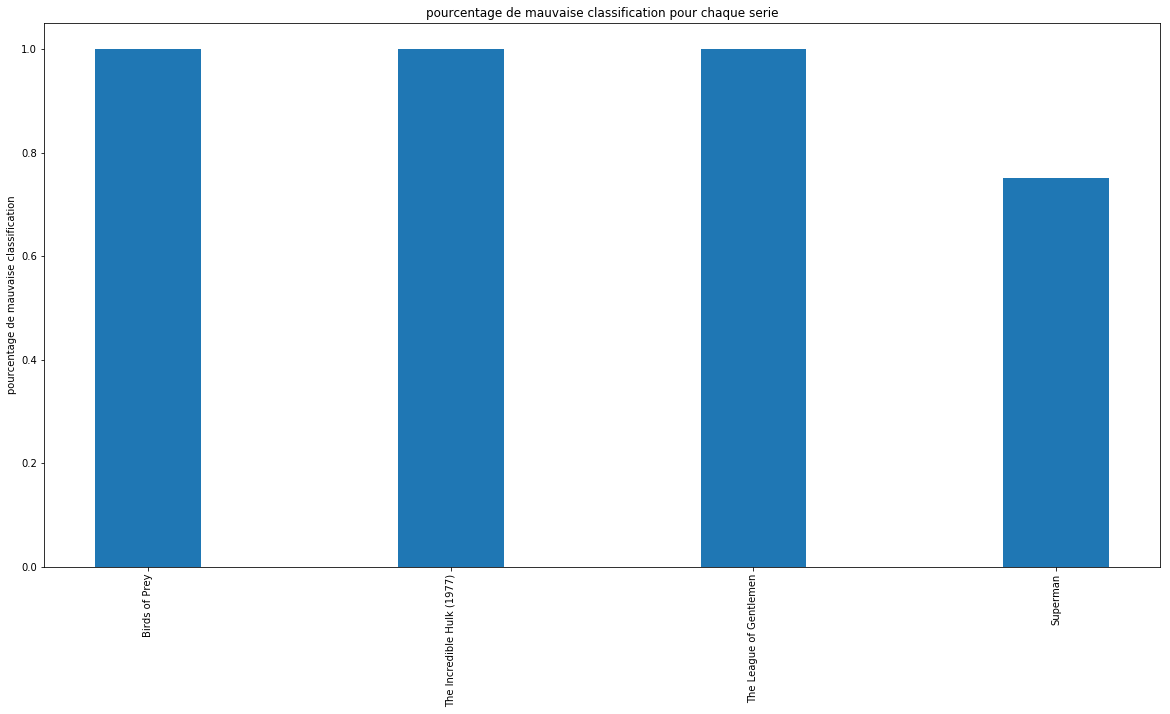

In [8]:
errors = NB.getErrors(y_test, listeSeries)

Ici encore, le constat est le même: notre classifieur est incapable de reconnaitre Birds of prey, ou Hulk. Ce sont toutes des séries avec très peu d'épisodes (une seule saison/une dizaine d'épisodes par saison).

#### augmentons le nombre de séries à classifier et observons l'évolution des performances: 
- essayons avec 100 séries différentes

In [16]:
listeSeries, (X_train, X_test, y_train, y_test) = load_data(path, series=[], nbclass=100, random=True, split=True, ratio=0.8)

#conversion des données sous forme vectorielle - nombre d'occurence
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=stopwords.words('english'), strip_accents='ascii')
count_vect.fit(X_train + X_test)

xtrain_count = count_vect.transform(X_train)
xtest_count = count_vect.transform(X_test)

print("countVector model:")

NB = NaiveBayes()
accuracy, predictions = NB.fit(xtrain_count, y_train, xtest_count, y_test)

countVector model:
trained on 2692 samples, validated on 673.
accuracy:  0.549777117384844


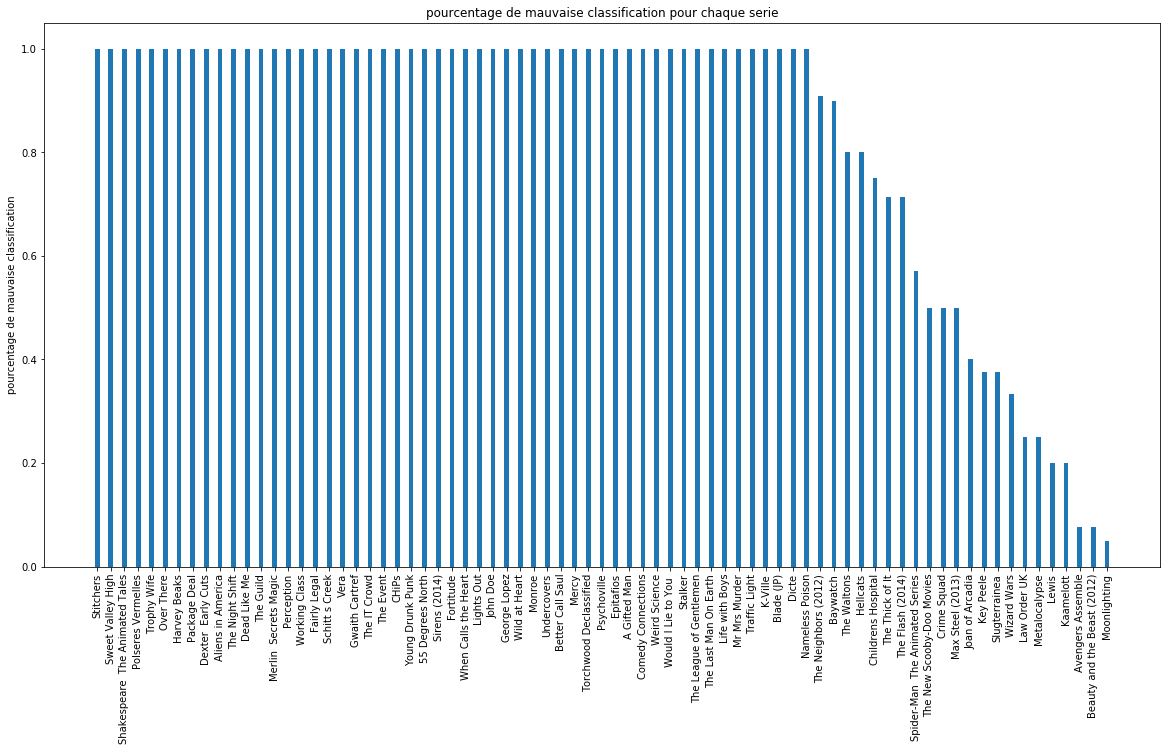

In [17]:
errors = NB.getErrors(y_test, listeSeries)

Résultat: 54% de bonne classification! en comparaison à l'aléatoire (1%) cette performance est très bonne.
Nous constatons encore une fois que les séries comportant le moins d'épisodes sont impossibles à reconnaitre pour le classifieur.

Pour confirmer cela, nous testons avec 100 séries encore une fois, mais cette fois les 100 Séries comportant le plus d'épisodes:

In [18]:
#l'option random=False permet d'indiquer que l'on veut les 100 séries comportant le plus d'épisodes
listeSeries, (X_train, X_test, y_train, y_test) = load_data(path, series=[], nbclass=100, random=False, split=True, ratio=0.8)

#conversion des données sous forme vectorielle - nombre d'occurence
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words=stopwords.words('english'), strip_accents='ascii')
count_vect.fit(X_train + X_test)

xtrain_count = count_vect.transform(X_train)
xtest_count = count_vect.transform(X_test)

print("countVector model:")

NB = NaiveBayes()
accuracy, predictions = NB.fit(xtrain_count, y_train, xtest_count, y_test)

countVector model:
trained on 15848 samples, validated on 3962.
accuracy:  0.7647652700656234


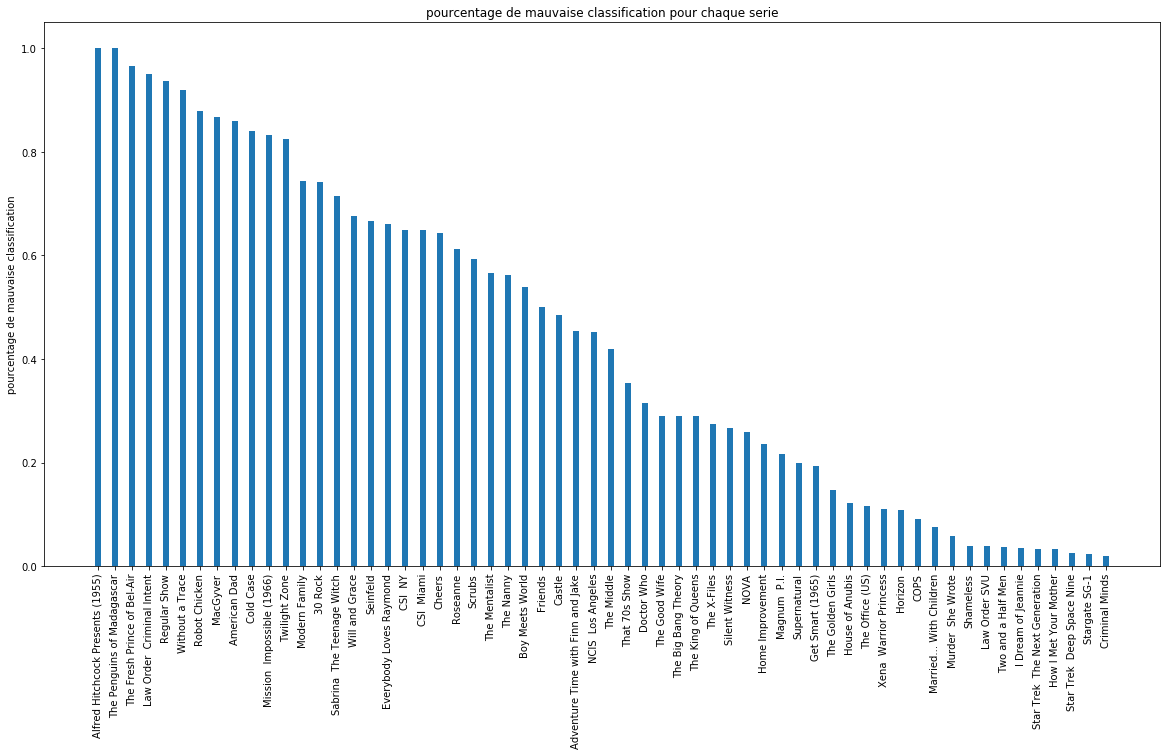

In [19]:
errors = NB.getErrors(y_test, listeSeries)

76% de bonne classification! Seulement 2 séries ne sont pas reconnaissables.
Esprits criminels, stargate SG-1, how i met your mother sont très bien reconnues.

- Passons maintenant au vecteur de tf-idf:

In [30]:
X_train, X_test, y_train, y_test = load_data(path, series=listeseries, split=True, ratio=0.8)

#vectorisation des données sous forme de vecteur de tf-idf pour les mots
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train + X_test)

xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

In [34]:
print("tf-idf word model:")
accuracy, predictions = NB.fit(xtrain_tfidf, y_train, xtest_tfidf, y_test)

tf-idf word model:
trained on 2039 samples, validated on 510.
accuracy:  0.34901960784313724


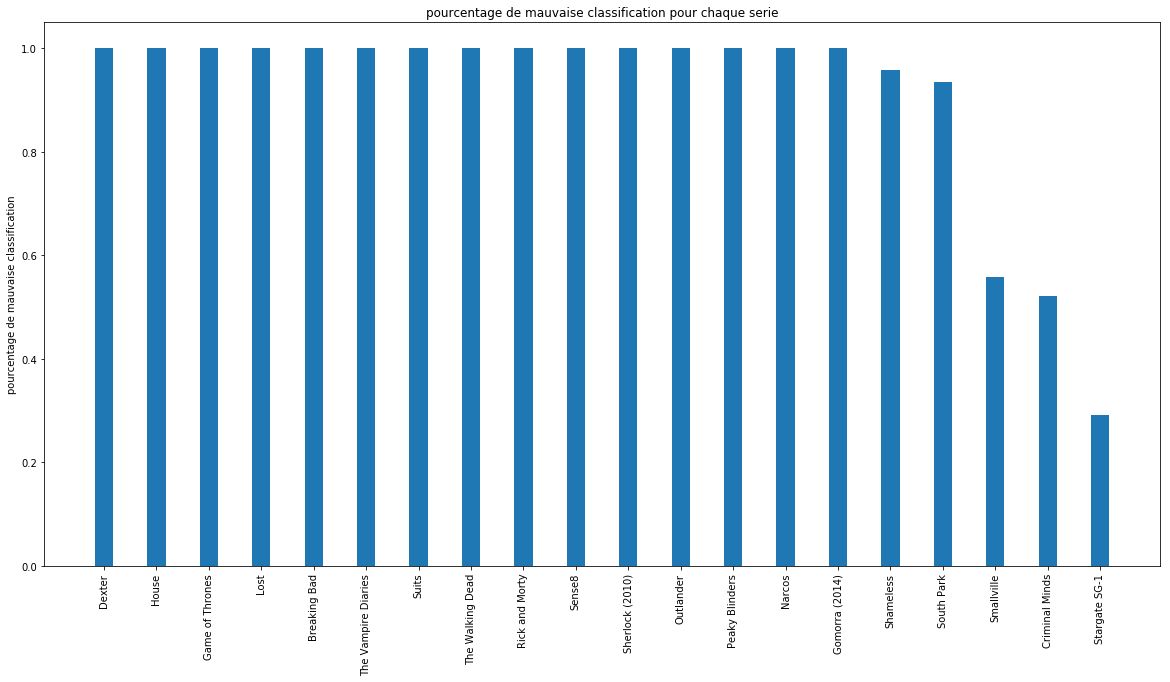

In [35]:
errors = NB.getErrors(y_test, listeseries)

Résultat: ce modèle est incapable de reconnaitre la plupart des séries les plus populaires. Nous allons tester d'autres modèles et reviendrons après sur ce modèle: il se pourrait que cela soit dû à la mauvaise qualité de la tokenization et à une absence de stemming, qui rend le modèle td-idf très inefficace.